In [1]:
#### ADD CUSTOM PATH ###
path_to_quant = '//home/gridsan/djuna/homer/github/confocalQuant'

In [134]:
import sys
import os
sys.path.append(path_to_quant)

from tqdm import tqdm 

from confocalQuant.segmentation import toggle_filters, load_3D, int_to_float, get_czi_files, import_im, run_med_filter, get_anisotropy, do_inference, toggle_segmentation, float_to_int, bgrnd_subtract, gamma_correct_image, extract_channels
from aicsimageio import AICSImage
from cellpose import models
import numpy as np
import pandas as pd

import numpy as np
from confocalQuant.segmentation import extract_sbatch_parameters, get_czi_files, impose_segmentation_all, toggle_filters
from confocalQuant.plotting import return_results, concatenate_Y, add_metadata, exclude_files, modify_keep_files, filter_data, get_out_files, is_string_present

### 1. Create metadata file

In [209]:
parent_path = '/home/gridsan/djuna/homer/github/confocalQuant/'
dirs = np.array(os.listdir('./'))
out_dirs = dirs[['neuron' in x for x in dirs]]
in_dirs = [x.split('_out')[0] for x in out_dirs]

In [210]:
all_data = []

for i in tqdm(range(len(in_dirs))):
    im_path_root = parent_path + 'data/' + in_dirs[i]
    out_path_root = parent_path + 'outs/' + out_dirs[i]
    
    in_file_names = get_czi_files(im_path_root)
    out_file_names = get_out_files(out_path_root)
    
    df = pd.DataFrame([x.split('.')[0] for x in in_file_names])
    df.columns = ['filename']
    df['ID'] = range(len(in_file_names))
    df['batch'] = in_dirs[i]
    wellname = [x.split('-')[0] for x in df['filename']]
    df['well_name'] = wellname
    dictionary = dict(zip([int(x.split('_')[1].split('.')[0]) for x in out_file_names], out_file_names))
    df['slurm_name'] = [dictionary[x] for x in df['ID']]
    
    add_metadata(df, im_path_root+'/temp.csv')
    
    all_data.append(df)

100%|██████████| 10/10 [00:00<00:00, 61.80it/s]


In [211]:
data = pd.DataFrame(np.vstack(all_data))
data.columns = ['filename', 'fileID', 'batch', 'well_name', 'slurm_file', 'treatment', 'line']

In [212]:
res = []
for i in tqdm(range(data.shape[0])):
    file = './'+data['batch'][i]+'_out/' + data['slurm_file'][i]
    res.append(is_string_present(file, 'done'))

100%|██████████| 389/389 [00:00<00:00, 1943.28it/s]


In [213]:
data['job_done'] = res
np.random.seed(5)
data['unique_image_ID'] = [np.random.randint(10**9, 10**10) for x in range(data.shape[0])]

In [214]:
data[np.invert(data['job_done'])]

,filename,fileID,batch,well_name,slurm_file,treatment,line,job_done,unique_image_ID


In [215]:
# assign unique ID to each image
len(np.unique(random_10_digit_number))==len(random_10_digit_number)

# can also add anisotropy and other confocal info to this datatable

True

In [216]:
# compute and save all projections
data

,filename,fileID,batch,well_name,slurm_file,treatment,line,job_done,unique_image_ID
0,C10,0,neuronbatch10132023_cellrox,C10,slurm-24409544_0.out,DGATi,Y622,True,5206684233
1,C2,1,neuronbatch10132023_cellrox,C2,slurm-24409544_1.out,vehicle,Y622,True,1385778404
2,C3,2,neuronbatch10132023_cellrox,C3,slurm-24409544_2.out,vehicle,Y622,True,8084371943
3,C4,3,neuronbatch10132023_cellrox,C4,slurm-24409544_3.out,CDP-choline,Y622,True,4519608859
4,C5,4,neuronbatch10132023_cellrox,C5,slurm-24409544_4.out,CDP-choline,Y622,True,2041703117
...,...,...,...,...,...,...,...,...,...
384,E08-1,17,neuronbatch101823_cellrox,E08,slurm-24409476_17.out,rosiglitazone,G2,True,9266303837
385,E10-1,18,neuronbatch101823_cellrox,E10,slurm-24409476_18.out,GW501516,G2,True,9026929263
386,F04-1,19,neuronbatch101823_cellrox,F04,slurm-24409476_19.out,CDP-choline,G2,True,5659531633
387,F06-1,20,neuronbatch101823_cellrox,F06,slurm-24409476_20.out,sn-glycero-3-phosphocholine,G2,True,5857174012


In [ ]:
# add the Y_data to this datatable

In [217]:
import numpy as np
from confocalQuant.segmentation import extract_sbatch_parameters, get_czi_files, impose_segmentation_all, toggle_filters
from confocalQuant.plotting import return_results, concatenate_Y, add_metadata, exclude_files, modify_keep_files, filter_data

In [248]:
# load & concatenate the data
path_to_sbatch_file = './neuronbatch11012023_cellrox_bodipy_out/run_jobs_110123_cellrox.sbatch'
mat, masks, Y, Ncells, Nzi, cells_per_job, zi_per_job = return_results(path_to_sbatch_file,  '.')
colnames = ['DAPI', 'NeuN', 'bodipy', 'cellrox', 'cellvolume', 'Npoints', 'bodipy-b', 'cellrox-b', 'ID']
Nfiles = Nfiles_dict['neuronbatch11012023_cellrox_bodipy']
Y_extracted = concatenate_Y(Nfiles, Y, cells_per_job, Ncells, colnames)

In [249]:
# concatenate this for each batch of data
Y_extracted

,DAPI,NeuN,bodipy,cellrox,cellvolume,Npoints,bodipy-b,cellrox-b,ID
0,36.745825,1209.580099,23.182841,152.599784,1177.971509,3026.0,23.169428,152.592228,0.0
1,34.260487,122.866891,15.460327,13.132347,397.458331,1021.0,15.446913,13.124791,0.0
2,59.248197,106.233446,11.408174,9.877345,358.919277,922.0,11.394761,9.869788,0.0
3,47.470086,260.703538,25.911445,20.148618,708.885036,1821.0,25.898032,20.141062,0.0
4,147.770824,286.742998,483.667186,27.790443,1024.593857,2632.0,483.653772,27.782886,0.0
...,...,...,...,...,...,...,...,...,...
4174,94.365992,74.004347,22.844552,17.212010,493.222043,1267.0,22.835498,17.204997,23.0
4175,98.365766,165.053029,46.064005,33.382095,666.842431,1713.0,46.054951,33.375083,23.0
4176,65.339642,39.614897,12.434362,9.388876,244.080680,627.0,12.425307,9.381863,23.0
4177,53.411653,74.415764,20.289889,17.576626,338.287258,869.0,20.280834,17.569613,23.0


In [242]:
x, y = np.unique(data['batch'], return_counts=True)
Nfiles_dict = dict(zip(x,y))

24

In [247]:
def concatenate_Y(Nfiles, all_Y, cells_per_job, Ncells_per_job, colnames):
    res = []
    for ID in range(Nfiles):
        start = ID*cells_per_job
        end = start + Ncells_per_job[ID][0]
        temp = all_Y[start:end]
        res.append(temp)
        
    data = pd.DataFrame(np.vstack(res))
    data.columns = colnames 
    
    return data


In [ ]:
out_files = get_out_files('./')
out_files = np.array(out_files)[np.argsort([int(x.split('_')[1].split('.')[0]) for x in out_files])]
res = []
for file in out_files:
    res.append((file, is_string_present(file, 'done')))
    
res

In [4]:
# compute mean projections for each image from each batch
# toggle through at random
# save batch-file IDs that are flagged
# concatenate all Ys
# add batch ID
# add batch-im ID
# add flagged column

In [ ]:
# check consistency of all settings for images within a batch
# check that all sbatch files are completed

In [ ]:
#### SPECIFY PATH TO SBATCH FILE ###
path_to_sbatch_file = './neuronbatch11012023_cellrox_bodipy_out/run_jobs_110123_cellrox.sbatch'
path_to_czi_files = '../data/neuronbatch11012023_cellrox_bodipy/'
nuclear_col_idx = 0
soma_col_idx = 1
nuclear_percentile = 0 
soma_percentile = 0
colnames = ['DAPI', 'NeuN', 'bodipy', 'cellrox', 'cellvolume', 'Npoints', 'bodipy-b', 'cellrox-b', 'ID']
path_to_meta = '../../data/neuronbatch11012023_cellrox_bodipy/temp.csv'

### 5. 
Toggle through the segmentation results to evaluate them.

In [27]:
# toggle through segmentation
extracted = extract_channels([1], g_correct) # enter which channels to show here (up to 3 channels)
toggle_segmentation(float_to_int(extracted), masks) # you can optionally pass out_float, out_med, out_float_subtract, or apply different filters to out_float to help with the visualization

### 6. 
You may want to repeat steps 1-5 to make sure the parameters you are choosing work well for different images.
Once you've found good parameters, modify the example.sbatch file to do inference on all your images.

```bash
sbatch example.sbatch
```

In [6]:
from confocalQuant.plotting import get_out_files, is_string_present
from tqdm import tqdm

In [9]:
# Do all the SBATCH files for the IDs we care about say done?

out_files = get_out_files('./')
out_files = np.array(out_files)[np.argsort([int(x.split('_')[1].split('.')[0]) for x in out_files])]
res = []
for file in out_files:
    res.append((file, is_string_present(file, 'done')))
    
res

[('slurm-24399566_0.out', True),
 ('slurm-24399715_1.out', True),
 ('slurm-24399715_2.out', True),
 ('slurm-24399715_3.out', False),
 ('slurm-24399715_4.out', True),
 ('slurm-24399715_5.out', True),
 ('slurm-24399715_6.out', True),
 ('slurm-24399715_7.out', True),
 ('slurm-24399715_8.out', True),
 ('slurm-24399715_9.out', True),
 ('slurm-24399715_10.out', True),
 ('slurm-24399715_11.out', True),
 ('slurm-24399715_12.out', True),
 ('slurm-24399715_13.out', True),
 ('slurm-24399715_14.out', True),
 ('slurm-24399715_15.out', True),
 ('slurm-24399715_16.out', True),
 ('slurm-24399715_17.out', True),
 ('slurm-24399715_18.out', True),
 ('slurm-24399715_19.out', True),
 ('slurm-24399715_20.out', True),
 ('slurm-24399715_21.out', True),
 ('slurm-24399715_22.out', True),
 ('slurm-24399715_23.out', True)]

### 7. 

Load, explore, and plot quantifications of the results.

In [10]:
import numpy as np
from confocalQuant.segmentation import extract_sbatch_parameters, get_czi_files, impose_segmentation_all, toggle_filters
from confocalQuant.plotting import return_results, concatenate_Y, add_metadata, exclude_files, modify_keep_files, filter_data

In [11]:
#### SPECIFY PATH TO SBATCH FILE ###
path_to_sbatch_file = '../neuronbatch11012023_cellrox_bodipy_out/run_jobs_110123_cellrox.sbatch'
path_to_czi_files = '../../data/neuronbatch11012023_cellrox_bodipy/'
nuclear_col_idx = 0
soma_col_idx = 1
nuclear_percentile = 0 
soma_percentile = 0
colnames = ['DAPI', 'NeuN', 'bodipy', 'cellrox', 'cellvolume', 'Npoints', 'bodipy-b', 'cellrox-b', 'ID']
path_to_meta = '../../data/neuronbatch11012023_cellrox_bodipy/temp.csv'

In [12]:
# load & concatenate the data
mat, masks, Y, Ncells, Nzi, cells_per_job, zi_per_job = return_results(path_to_sbatch_file)
all_file_names = get_czi_files(path_to_czi_files)


In [15]:
Ncells_copy = Ncells.copy()
Ncells_copy[3] = 50
Nzi_copy = Nzi.copy()
Nzi_copy[3] = 30

In [17]:
data = concatenate_Y(all_file_names, Y, cells_per_job, Ncells_copy, nuclear_col_idx, soma_col_idx, nuclear_percentile, soma_percentile, colnames)
add_metadata(data, path_to_meta)

In [18]:
data.head()

,DAPI,NeuN,bodipy,cellrox,cellvolume,Npoints,bodipy-b,cellrox-b,ID,filename,wellname,treatment,line
0,36.745825,1209.580099,23.182841,152.599784,1177.971509,3026.0,23.169428,152.592228,0.0,F03-1,F03,vehicle,Y622
1,34.260487,122.866891,15.460327,13.132347,397.458331,1021.0,15.446913,13.124791,0.0,F03-1,F03,vehicle,Y622
2,59.248197,106.233446,11.408174,9.877345,358.919277,922.0,11.394761,9.869788,0.0,F03-1,F03,vehicle,Y622
3,47.470086,260.703538,25.911445,20.148618,708.885036,1821.0,25.898032,20.141062,0.0,F03-1,F03,vehicle,Y622
4,147.770824,286.742998,483.667186,27.790443,1024.593857,2632.0,483.653772,27.782886,0.0,F03-1,F03,vehicle,Y622


In [19]:
data['NeuN_per_point'] = data['NeuN']/data['Npoints']
data['DAPI_per_point'] = data['DAPI']/data['Npoints']
data['cellrox-b_per_point'] = data['cellrox-b']/data['Npoints']
data['bodipy-b_per_point'] = data['bodipy-b']/data['Npoints']

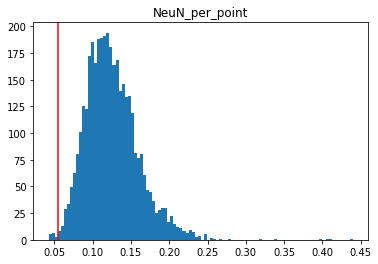

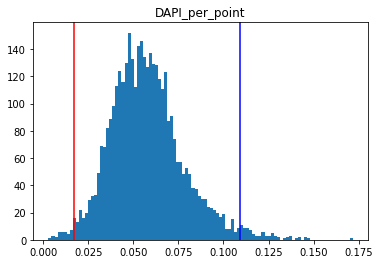

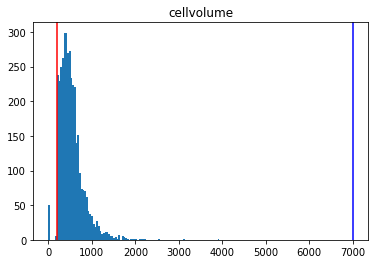

In [25]:
# filter cells based on NeuN and DAPI
data_filtered = filter_data(data, 'NeuN_per_point', 'DAPI_per_point', 'cellvolume', 'wellname', lower_thresh_vol = 200, upper_thresh_vol = 7000, C_nuc=2, C_soma=2, C_nuc_upper=2.5)
# update masks based on this for toggling

In [26]:
data_filtered.shape

(3613, 17)

In [27]:
channels = [0,1,2,3] #### ADD CUSTOM CHANNELS ####

In [38]:
# toggle segmentation
val = 0.5
out_float = []
for i in tqdm(range(len(keep_files_index))): #
    out_float.append(impose_segmentation_all(keep_files_index[i], zi_per_job, Nzi, mat, masks, val, data, data_filtered, hide=True))

100%|██████████| 23/23 [00:50<00:00,  2.21s/it]


In [39]:
toggle_filters(keep_files_index, parent_path, channels, out_float)

### 8. 
Remove cells from flagged images

In [40]:
# specify additional images to remove
ids_remove = set([])
keep_files = set(keep_files_index[[x not in ids_remove for x in keep_files_index]])

# modify data to only include the keep_files IDs
data_filtered = data_filtered[[int(x) in keep_files for x in data_filtered['ID']]]

In [41]:
data_filtered.shape

(3613, 17)

In [43]:
data.shape

(3830, 17)

In [44]:
data['condition'] = data['treatment']+'_' + data['line']


In [45]:
data_filtered['condition'] = data_filtered['treatment']+'_' + data_filtered['line']
data_filtered

,DAPI,NeuN,bodipy,cellrox,cellvolume,Npoints,bodipy-b,cellrox-b,ID,filename,wellname,treatment,line,NeuN_per_point,DAPI_per_point,cellrox-b_per_point,bodipy-b_per_point,condition
1,34.260487,122.866891,15.460327,13.132347,397.458331,1021.0,15.446913,13.124791,0.0,F03-1,F03,vehicle,Y622,0.120340,0.033556,0.012855,0.015129,vehicle_Y622
2,59.248197,106.233446,11.408174,9.877345,358.919277,922.0,11.394761,9.869788,0.0,F03-1,F03,vehicle,Y622,0.115221,0.064261,0.010705,0.012359,vehicle_Y622
3,47.470086,260.703538,25.911445,20.148618,708.885036,1821.0,25.898032,20.141062,0.0,F03-1,F03,vehicle,Y622,0.143165,0.026068,0.011060,0.014222,vehicle_Y622
4,147.770824,286.742998,483.667186,27.790443,1024.593857,2632.0,483.653772,27.782886,0.0,F03-1,F03,vehicle,Y622,0.108945,0.056144,0.010556,0.183759,vehicle_Y622
5,61.648475,194.292999,17.373152,21.350518,552.782400,1420.0,17.359738,21.342962,0.0,F03-1,F03,vehicle,Y622,0.136826,0.043414,0.015030,0.012225,vehicle_Y622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3825,94.365992,74.004347,22.844552,17.212010,493.222043,1267.0,22.835498,17.204997,23.0,G11-1,G11,DGAT1/2i,Y622,0.058409,0.074480,0.013579,0.018023,DGAT1/2i_Y622
3826,98.365766,165.053029,46.064005,33.382095,666.842431,1713.0,46.054951,33.375083,23.0,G11-1,G11,DGAT1/2i,Y622,0.096353,0.057423,0.019483,0.026886,DGAT1/2i_Y622
3827,65.339642,39.614897,12.434362,9.388876,244.080680,627.0,12.425307,9.381863,23.0,G11-1,G11,DGAT1/2i,Y622,0.063182,0.104210,0.014963,0.019817,DGAT1/2i_Y622
3828,53.411653,74.415764,20.289889,17.576626,338.287258,869.0,20.280834,17.569613,23.0,G11-1,G11,DGAT1/2i,Y622,0.085634,0.061463,0.020218,0.023338,DGAT1/2i_Y622


In [46]:
np.unique(data_filtered['condition'], return_counts = True)

(array(['CDP-choline_Y622', 'DGAT1/2i_Y622', 'GW501516_Y622',
        'rosiglitazone_Y622', 'sn-glycero-3-phosphocholine_Y622',
        'vehicle_Y622'], dtype=object),
 array([511, 572, 614, 674, 646, 596]))

In [47]:
np.unique(data['condition'], return_counts = True)

(array(['CDP-choline_Y622', 'DGAT1/2i_Y622', 'GW501516_Y622',
        'rosiglitazone_Y622', 'sn-glycero-3-phosphocholine_Y622',
        'vehicle_Y622'], dtype=object),
 array([552, 602, 635, 694, 666, 681]))

In [45]:
# #### SPECIFY ADDITIONAL IDS TO REMOVE ####
# Ncells_per_file = 50 # specify min Ncells per file
# files, counts = np.unique(data_filtered['wellname'], return_counts=True)
# keep_files = np.argwhere([x.split('-')[0] in set(files[counts>Ncells_per_file]) for x in all_file_names]).reshape(-1)
# ids_remove = set([2,0]) # additional IDs to remove
# keep_files = set(keep_files[[x not in ids_remove for x in keep_files]])



### 9. 
Plot effects

In [48]:
from confocalQuant.plotting import plot_effect
import matplotlib.pyplot as plt

In [53]:
import seaborn as sns
set1_colors = sns.color_palette('husl')

colors = dict(zip(np.unique(data['treatment']), set1_colors[:6]))

(0.0, 0.04)

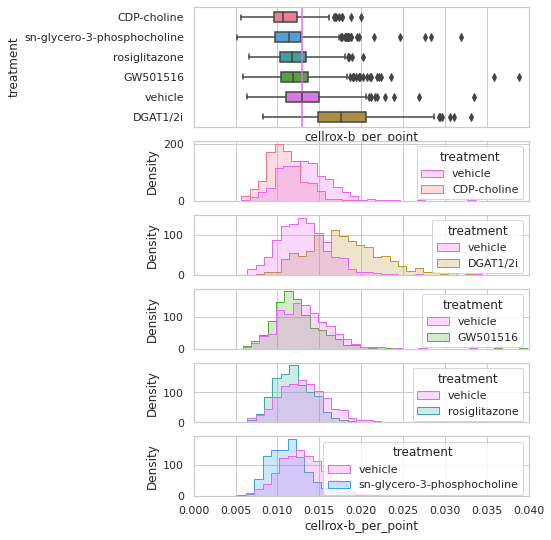

In [69]:
plot_all_effects(data_filtered, 'Y622', 'cellrox-b_per_point', 'density', colors)
plt.xlim(0,0.04)

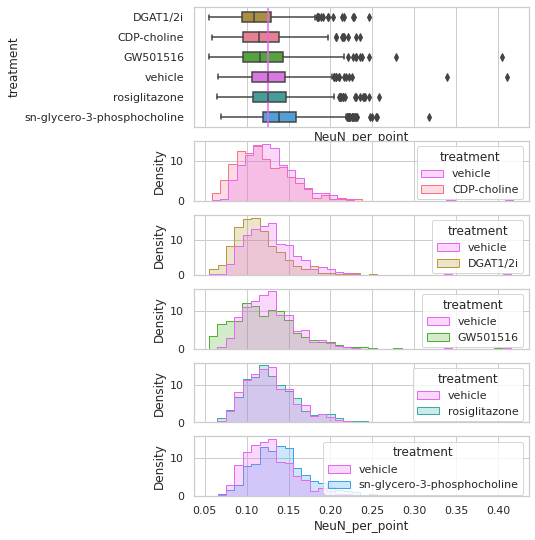

In [71]:
plot_all_effects(data_filtered, 'Y622', 'NeuN_per_point', 'density', colors, 0.01)
#plt.xlim(0,0.04)

In [110]:
np.sum(data_filtered['bodipy-b_per_point']>0.001)


3613

(0.0, 0.1)

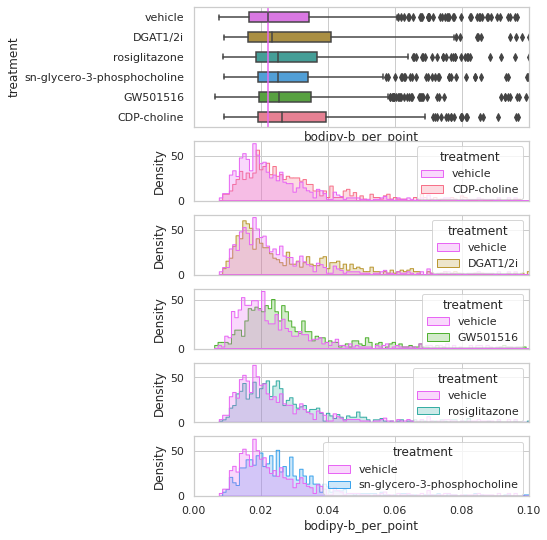

In [122]:
plot_all_effects(data, 'Y622', 'bodipy-b_per_point', 'density', colors, 0.001)
plt.xlim(0,0.1)

In [64]:
def plot_all_effects(data, cellline, x, stat, colors, bw=0.001):
    sns.set(rc={'figure.figsize':(6,9)})
    sns.set_style("whitegrid")
    index_all = data['line']==cellline

    treatments = np.unique(data[index_all]['treatment'])
    f, ax = plt.subplots(len(treatments), sharex=True, gridspec_kw={"height_ratios": (1,.5,.5,.5,.5,.5)})
    
    treatment = np.unique(data[index_all]['treatment'])
    
    treatment = treatment[[x not in 'vehicle' for x in treatment]]

    names = (data[index_all].groupby('treatment')[x].median())
    order = names.index[np.argsort(names)]

    sns.boxplot(data=data[index_all], x=x, y='treatment',orient="h", ax=ax[0], width=.5, dodge=True, order =(order), palette = colors)
    ax[0].axvline(x=names['vehicle'], color = colors['vehicle'])
        
    for i in range(len(ax)-1):
        index = (data['line'] == cellline) & (data['treatment']=='vehicle') | (data['treatment']==treatment[i])
        sns.histplot(data=data[index], x=x, ax=ax[i+1], hue='treatment', binwidth=bw, palette=colors, element="step", common_norm=False, stat=stat)
    


In [ ]:
# mixed model quantification

In [ ]:
# check that all images used have <40 Zi, <300 cells, physical pixel size, pinhole size etc 

### 10.
Representative images.

In [123]:
from confocalQuant.segmentation import bgrnd_subtract, gamma_correct_image, extract_channels, impose_segmentation, float_to_int, hide_masks
from confocalQuant.plotting import add_scale_bar, add_inset, plot_axis, get_id_data, get_mean_projections, compute_avs, get_rep_im
import numpy as np
import matplotlib.pyplot as plt
from aicsimageio import AICSImage


In [150]:
treatments = np.unique(data_filtered['treatment'])

In [151]:
# get rep images
dict_treat = dict(zip(data['filename'], data['treatment']))
dict_line = dict(zip(data['filename'], data['line']))

mean_per_filename, mean_per_condition = compute_avs(data_filtered, 'filename', 'treatment', 'line', 'cellrox-b_per_point')
#treatments = treatments[[0,4,5]]
rep = []
for i in treatments:
    rep.append(get_rep_im(i, 'Y622', all_files_present, mean_per_condition, mean_per_filename, dict_treat, dict_line))

In [152]:
collabs = ['NeuN','NeuN+DAPI',  'NeuN Mask', 'Cellrox']
rowlabs = treatments

In [153]:
treatments

array(['CDP-choline', 'DGAT1/2i', 'GW501516', 'rosiglitazone',
       'sn-glycero-3-phosphocholine', 'vehicle'], dtype=object)

In [155]:
mat_sele, mask_sele = get_id_data(rep[-1], zi_per_job, Nzi, mat, masks)
upper = np.percentile(mat_sele[:,:,:,2], 99.5)

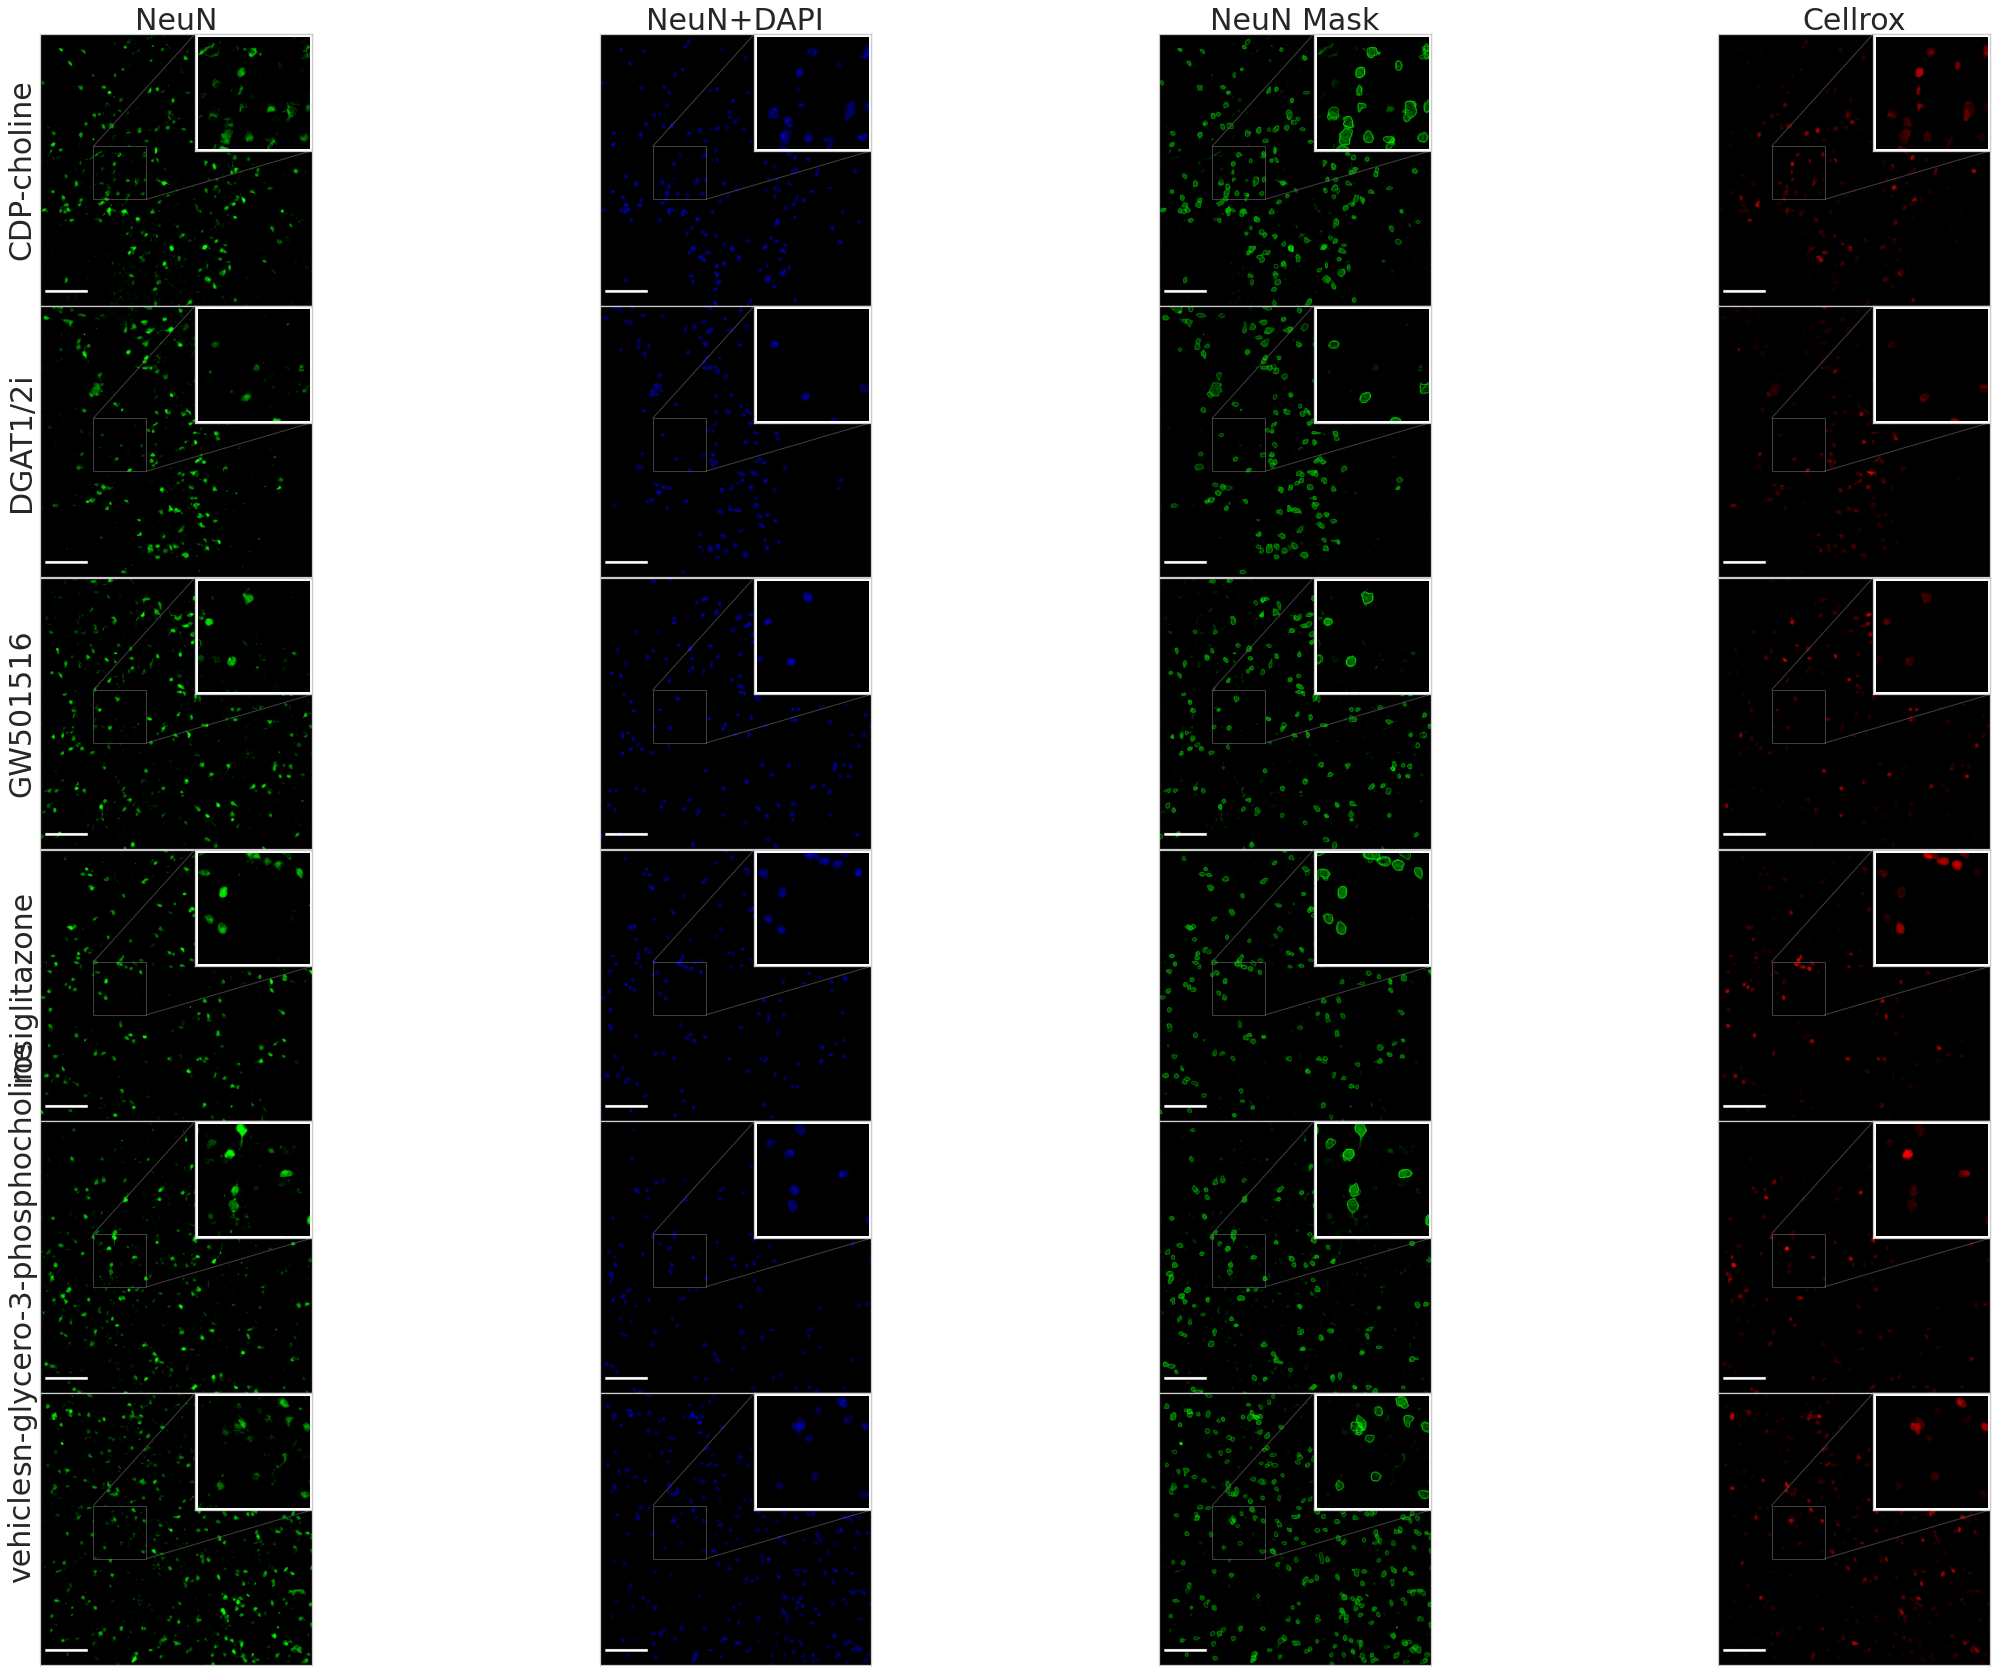

In [156]:
# get data for a specific ID
conditions = rep
fig, axes = plt.subplots(6, 4, figsize=(40, 30))#figsize=(27, 40))
fig.subplots_adjust(hspace=0.001, wspace=0.01)  # Adjust the spacing

for i in range(len(conditions)):
    ID = conditions[i]
    mat_sele, mask_sele = get_id_data(ID, zi_per_job, Nzi, mat, masks)
    mat_sele[:,:,:,2] = ((np.clip(mat_sele[:,:,:,2], 0, upper)/upper))
    mask_sele = hide_masks(data, ID, data_filtered, mask_sele)
    
    # make plots
    plt0 = get_mean_projections(mat_sele, mask_sele, background_dict={0: 0, 1: 99.5, 2: 0}, gamma_dict={0: .5, 1: .5, 2: .5}, lower_dict={0: 0, 1: 0, 2: 0}, upper_dict={0: 100, 1: 99.9, 2: 100}, channels=[0], order=[2,1,0], mask_channel = [0], maskit=True)
    plt1 = get_mean_projections(mat_sele, mask_sele, background_dict={0: 0, 1: 99, 2: 0}, gamma_dict={0: .5, 1: .5, 2: 1}, lower_dict={0: 0, 1: 0, 2: 0}, upper_dict={0: 100, 1: 100, 2: 100}, channels=[2], order=[2,1,0], mask_channel = [2], maskit=True)
    d = impose_segmentation(mask_sele, mat_sele, val=1)
    plt2 = get_mean_projections(d, mask_sele, background_dict={0: 0, 1: 99, 2: 0}, gamma_dict={0: .5, 1: .5, 2: .5}, lower_dict={0: 0, 1: 0, 2: 0}, upper_dict={0: 100, 1: 99.9, 2: 100}, channels=[1], order=[2,1,0], mask_channel = [0], maskit=True)
    plt3 = get_mean_projections(mat_sele, mask_sele, background_dict={0: 0, 1: 99.5, 2: 0}, gamma_dict={0: .5, 1: .5, 2: .5}, lower_dict={0: 0, 1: 0, 2: 0}, upper_dict={0: 100, 1: 99.9, 2: 100}, channels=[1], order=[2,1,0], mask_channel = [0], maskit=True)

    # get image
    imgA = AICSImage(path_to_czi_files + all_file_names[ID])

    # show plots
    plot_axis(axes, plt3, i,0, 100, imgA, collabs, rowlabs)
    add_inset(axes, i,0, plt3)

    plot_axis(axes, plt2, i,2, 100, imgA, collabs, rowlabs)
    add_inset(axes, i,2, plt2)

    plot_axis(axes, plt0, i,1, 100, imgA, collabs, rowlabs)
    add_inset(axes, i,1, plt0)

    plot_axis(axes, plt1, i,3, 100, imgA, collabs, rowlabs)
    add_inset(axes, i,3, plt1)
    


#fig.savefig('test.png')


In [24]:
# add mixed model quantification to account for well effects
# check the KDE plot
# some quantification of FPR and TPR to take into account for effect size quantification etc 

# print how much the magnification is in upper right corner
# add thresholding across two images so that comparable (upper=99.9%)


(6900, 5)